<a href="https://colab.research.google.com/github/mkan1/ait-deep-learning/blob/main/extra_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Copyright

<PRE>
You may use and modify this code for research and development purpuses.
Using this code for educational purposes (self-paced or instructor led) without the permission of the author is prohibited.

Copyright (c) 2023 Bálint Gyires-Tóth - All Rights Reserved
</PRE>

## Introduction to Generative Adversarial Networks (GANs) for MNIST Dataset

In this notebook, we'll explore Generative Adversarial Networks (GANs), a fascinating deep learning technique that has gained significant attention in recent years. We'll focus on using GANs for generating handwritten digits, based on the popular MNIST dataset. This notebook shows an example for the basic GAN architecture, generated images are unconditioned. 

GANs were introduced by Ian Goodfellow and his colleagues in 2014, and they have since revolutionized the field of generative modeling. GANs consist of two neural networks, a generator and a discriminator, that compete against each other in a zero-sum game. The generator tries to create realistic data samples, while the discriminator's goal is to determine whether the samples are real (from the actual dataset) or fake (generated by the generator). Through this adversarial process, the generator becomes better at creating realistic data, while the discriminator improves its ability to distinguish between real and fake samples.

In [1]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential, Model

import matplotlib.pyplot as plt
import numpy as np

Class called GAN_image that encapsulates the logic for building and training a Generative Adversarial Network (GAN) for generating images. The class contains three main methods: build_discriminator, build_generator, and the class constructor __init__.


In [3]:

class GAN_image():

  """ 
  This method initializes the GAN_image class and compiles the models. It sets the image dimensions, defines the optimizer, and calls the 
  """
  def __init__(self):
    self.img_rows = 28
    self.img_cols = 28
    self.channels = 1
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.latent_dim = 100 # noise dim
    optimizer = keras.optimizers.legacy.Adam(0.0002, 0.5)
    
    self.discriminator = self.build_discriminator() # building discriminator
    self.discriminator.compile(loss = 'binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) # classify fake and real images
    
    self.generator = self.build_generator() # building generator
    
    z = Input(shape=(self.latent_dim,)) # input is noise
    img = self.generator(z) # generator generates image from noise
    
    # training generator only
    self.discriminator.trainable = False
    # discriminator determines if the generated image is real or fake
    validity = self.discriminator(img)
    
    # combined model, both generator and discriminator
    self.combined = Model(z, validity) # input: noise, output: discriminator output
    self.combined.compile(loss = 'binary_crossentropy', optimizer=optimizer) 

  """
  This method creates the discriminator model, which is responsible for classifying images as real (from the dataset) or fake (generated by the generator). The model is a simple feedforward neural network with the following layers:

  Flatten: Converts the 28x28x1 input image into a 1D vector.
  Dense layers: Three fully connected layers with 512, 256, and 1 neurons, respectively.
  LeakyReLU: Non-linear activation functions with a small slope for negative input values.
  Sigmoid activation: Converts the final output to a probability (0 to 1) representing whether the input image is real or fake.
  """
  def build_discriminator(self): 
    model = Sequential()
    
    model.add(Flatten(input_shape = self.img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2)) 
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid')) # single output for binary classification with the correct activation function
    
    print("Discriminator")
    model.summary()
    
    img = Input(shape=self.img_shape)
    
    validity = model(img)
    
    return Model(img, validity)
  
  """
  This method creates the generator model, which takes random noise as input and generates a 28x28x1 image as output. The generator is also a feedforward neural network with the following layers:

  Dense layers: Four fully connected layers with 256, 512, 1024, and np.prod(self.img_shape) neurons, respectively.
  LeakyReLU: Non-linear activation functions with a small slope for negative input values.
  BatchNormalization: Normalizes the activations of the previous layer to improve training stability.
  Tanh activation: Scales the final output values between -1 and 1.
  Reshape: Converts the 1D output vector into a 28x28x1 image.
  """
  def build_generator(self):
    model = Sequential()
    
    model.add(Dense(256, input_dim = self.latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8)) 
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(np.prod(self.img_shape), activation='tanh'))
    model.add(Reshape(self.img_shape))
    
    print("Generator")
    model.summary()
    
    noise = Input(shape=(self.latent_dim,))
    img = model(noise)
    
    return Model(noise, img)
  
  

In [4]:
# training parameters
steps           = 30000
batch_size      = 256
# creating the GAN
gan = GAN_image()

Discriminator
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 1)                 257       
                                                                 
Total params: 533,505
Trainable params: 53

In [5]:
# loading the dataset
from keras.datasets import mnist
(x_train, _), (_, _) = mnist.load_data()

# scaling images 
x_train = x_train / 127.5 - 1
x_train = np.expand_dims(x_train, axis = 3) # legyen channel dim is

# defining outputs for discriminator (real and fake)
valid = np.ones((batch_size, 1)) # D(x)    = 1
fake = np.zeros((batch_size, 1)) # D(G(z)) = 0


11490434/11490434 [==============================] - 1s 0us/step


In [6]:
# dispalying generated images
from IPython import display
def plot_images(gan, step):
  r, c = 2,10
  noise = np.random.normal(0, 1, (r * c, gan.latent_dim))
  gen_imgs = gan.generator.predict(noise,verbose=0)
  
  # átskálázás: 0-1 (from -1 -- 1)
  gen_imgs = 0.5 * gen_imgs + 0.5
  
  plt.title('step ' + str(step))
  fig, ax = plt.subplots(r, c)
  cnt = 0
  for i in range(r):
    for j in range(c):
      ax[i,j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
      ax[i,j].axis('off')
      cnt += 1
  
  display.display(plt.gcf())
      

8/8 [==============================] - 3s 2ms/step
0 loss_D 0.689234048128128 loss_G 0.9539138078689575


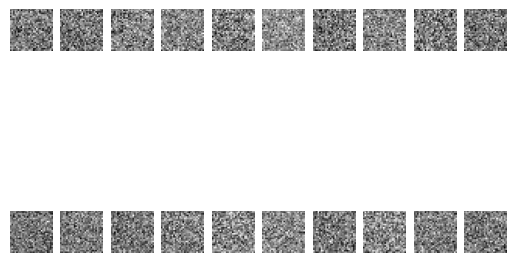

8/8 [==============================] - 0s 2ms/step
100 loss_D 0.10204735770821571 loss_G 3.3272182941436768


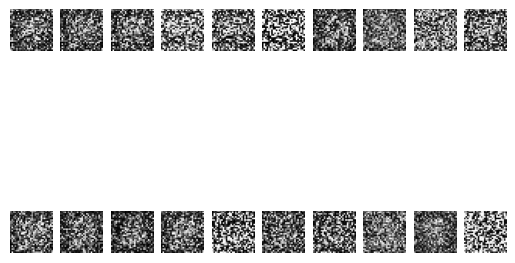

8/8 [==============================] - 0s 2ms/step
200 loss_D 0.3500170111656189 loss_G 2.61910343170166


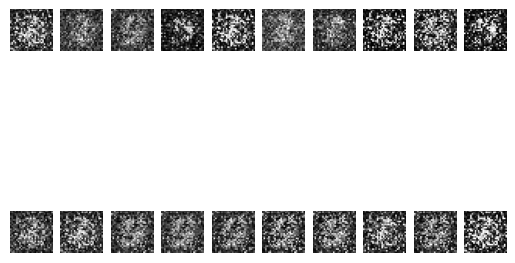

8/8 [==============================] - 0s 3ms/step
300 loss_D 0.6582957953214645 loss_G 0.6496567130088806


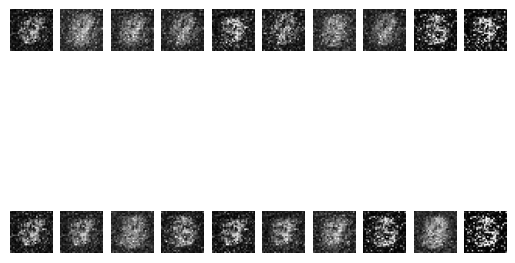

8/8 [==============================] - 0s 2ms/step
400 loss_D 0.6616449654102325 loss_G 0.6604907512664795


8/8 [==============================] - 0s 4ms/step
500 loss_D 0.6255098283290863 loss_G 0.7137288451194763


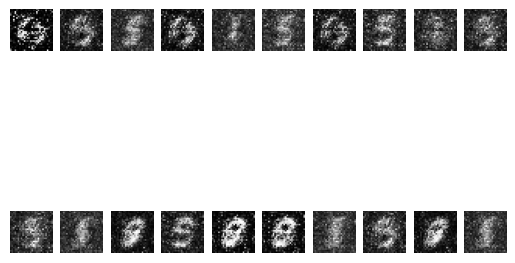

8/8 [==============================] - 0s 3ms/step
600 loss_D 0.6290252208709717 loss_G 0.7694819569587708


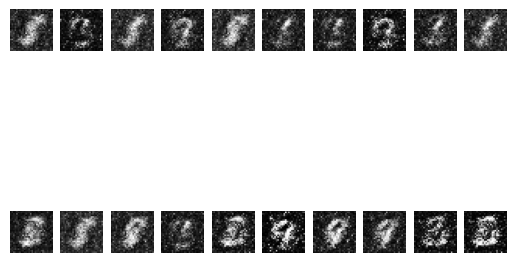

8/8 [==============================] - 0s 2ms/step
700 loss_D 0.5986385643482208 loss_G 0.8411763906478882


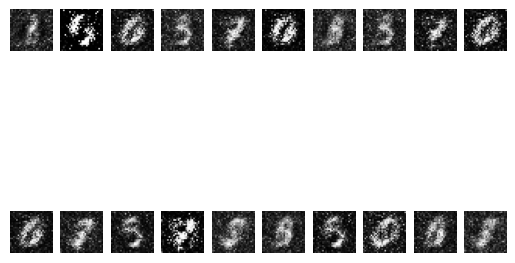

8/8 [==============================] - 0s 3ms/step
800 loss_D 0.5950618982315063 loss_G 0.854741096496582


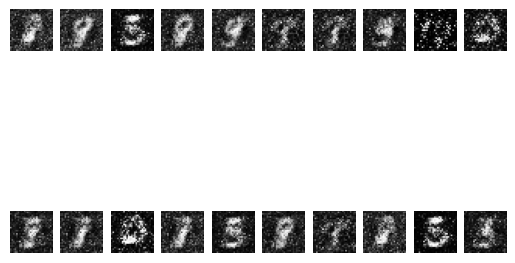

8/8 [==============================] - 0s 3ms/step
900 loss_D 0.5888014435768127 loss_G 0.901197075843811


8/8 [==============================] - 0s 4ms/step
1000 loss_D 0.5917283296585083 loss_G 0.9801578521728516


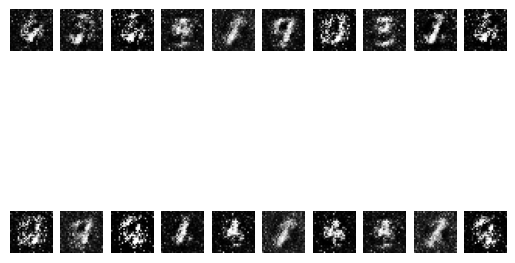

8/8 [==============================] - 0s 3ms/step
1100 loss_D 0.5829990208148956 loss_G 1.01675546169281


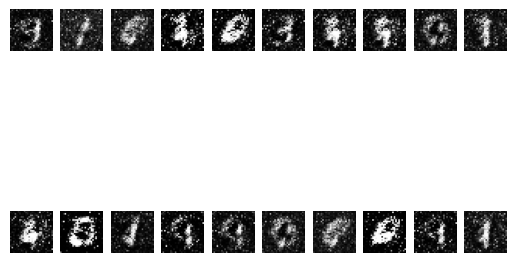

8/8 [==============================] - 0s 4ms/step
1200 loss_D 0.5856481492519379 loss_G 1.0599980354309082


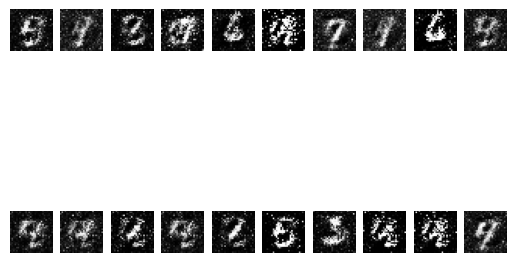

8/8 [==============================] - 0s 3ms/step
1300 loss_D 0.5614379942417145 loss_G 1.1057047843933105


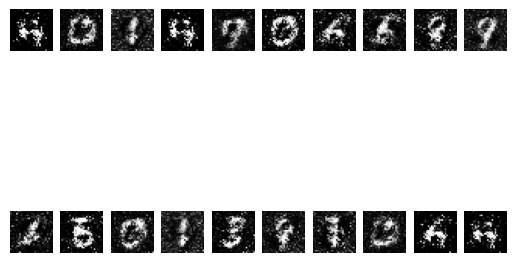

8/8 [==============================] - 0s 3ms/step
1400 loss_D 0.5264650136232376 loss_G 1.1266084909439087


8/8 [==============================] - 0s 3ms/step
1500 loss_D 0.5777247548103333 loss_G 1.0555775165557861


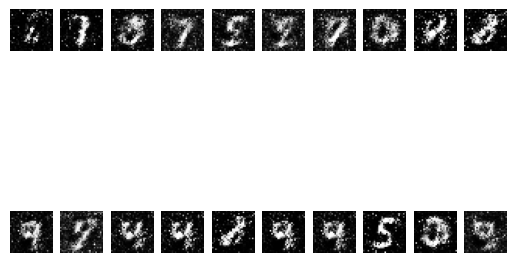

8/8 [==============================] - 0s 3ms/step
1600 loss_D 0.5448803603649139 loss_G 1.1131298542022705


8/8 [==============================] - 0s 3ms/step
1700 loss_D 0.5453699827194214 loss_G 1.1368190050125122


8/8 [==============================] - 0s 3ms/step
1800 loss_D 0.5656879842281342 loss_G 1.1003950834274292


8/8 [==============================] - 0s 3ms/step
1900 loss_D 0.5285324305295944 loss_G 1.17822265625


<ipython-input-6-17cbab5cbae4>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(r, c)


8/8 [==============================] - 0s 3ms/step
2000 loss_D 0.561462014913559 loss_G 1.1184481382369995


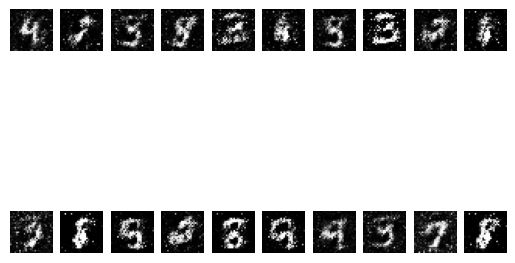

8/8 [==============================] - 0s 4ms/step
2100 loss_D 0.5551102459430695 loss_G 1.1361753940582275


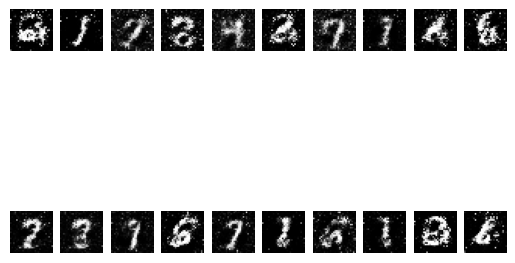

8/8 [==============================] - 0s 4ms/step
2200 loss_D 0.5601143538951874 loss_G 1.0755643844604492


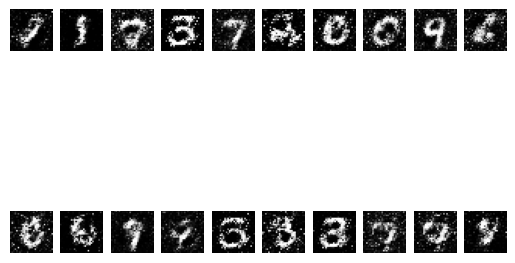

8/8 [==============================] - 0s 3ms/step
2300 loss_D 0.5918924510478973 loss_G 0.9968382120132446


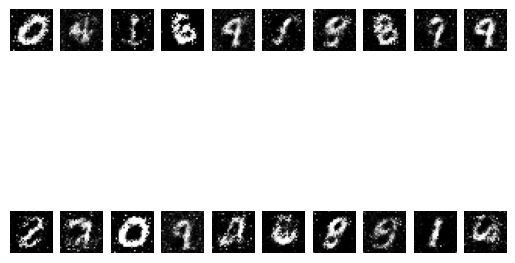

8/8 [==============================] - 0s 3ms/step
2400 loss_D 0.5659819543361664 loss_G 0.9964725971221924


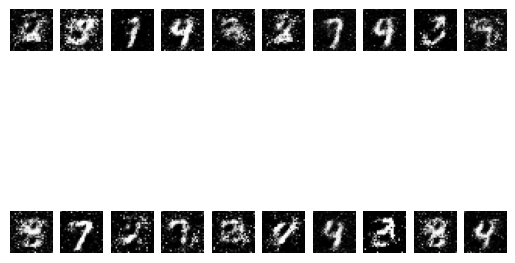

8/8 [==============================] - 0s 3ms/step
2500 loss_D 0.6402758657932281 loss_G 0.9634791016578674


8/8 [==============================] - 0s 4ms/step
2600 loss_D 0.6073856949806213 loss_G 0.9815112948417664


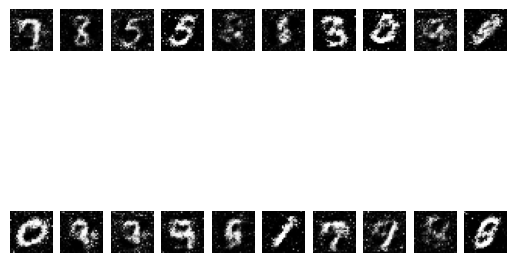

8/8 [==============================] - 0s 4ms/step
2700 loss_D 0.6287162601947784 loss_G 0.9521016478538513


8/8 [==============================] - 0s 3ms/step
2800 loss_D 0.6082257628440857 loss_G 0.9721031188964844


8/8 [==============================] - 0s 4ms/step
2900 loss_D 0.617588222026825 loss_G 0.9475086331367493


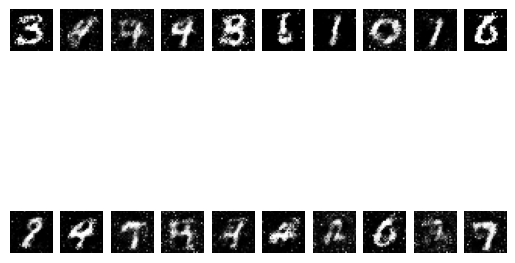

8/8 [==============================] - 0s 3ms/step
3000 loss_D 0.6187229454517365 loss_G 0.9373723268508911


8/8 [==============================] - 0s 3ms/step
3100 loss_D 0.6154772043228149 loss_G 0.9276418685913086


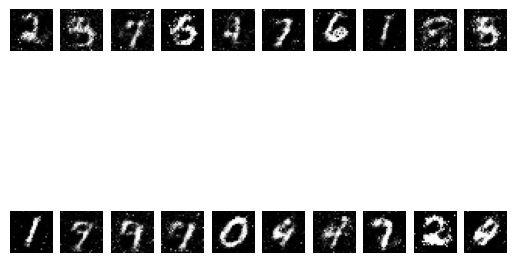

8/8 [==============================] - 0s 3ms/step
3200 loss_D 0.625912219285965 loss_G 0.9229903817176819


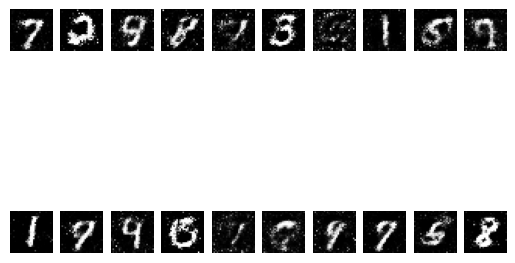

8/8 [==============================] - 0s 4ms/step
3300 loss_D 0.6410433351993561 loss_G 0.903748095035553


8/8 [==============================] - 0s 3ms/step
3400 loss_D 0.6293397545814514 loss_G 0.9029325842857361


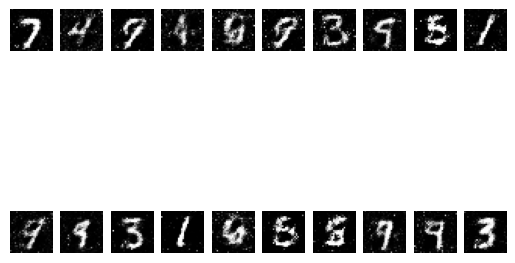

8/8 [==============================] - 0s 4ms/step
3500 loss_D 0.6457933783531189 loss_G 0.9248701333999634


8/8 [==============================] - 0s 3ms/step
3600 loss_D 0.6165810227394104 loss_G 0.9269869327545166


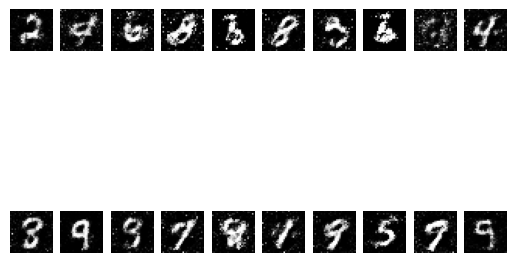

8/8 [==============================] - 0s 3ms/step
3700 loss_D 0.6311313211917877 loss_G 0.9364527463912964


8/8 [==============================] - 0s 4ms/step
3800 loss_D 0.6292813122272491 loss_G 0.9101317524909973


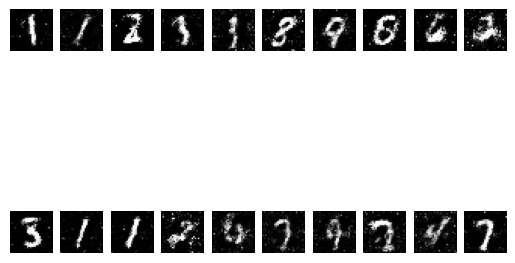

8/8 [==============================] - 0s 3ms/step
3900 loss_D 0.6293126940727234 loss_G 0.9077130556106567


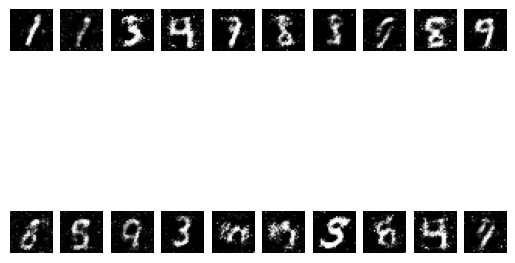

8/8 [==============================] - 0s 3ms/step
4000 loss_D 0.6221332848072052 loss_G 0.9314014911651611


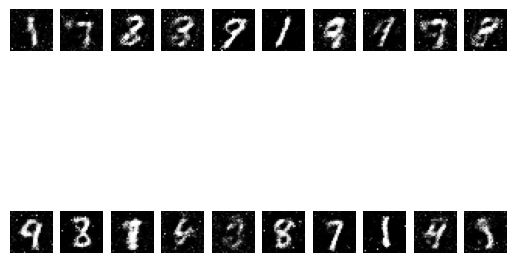

8/8 [==============================] - 0s 3ms/step
4100 loss_D 0.6532368063926697 loss_G 0.8796207904815674


8/8 [==============================] - 0s 3ms/step
4200 loss_D 0.6471912562847137 loss_G 0.9204339385032654


8/8 [==============================] - 0s 4ms/step
4300 loss_D 0.6521654427051544 loss_G 0.9252526760101318


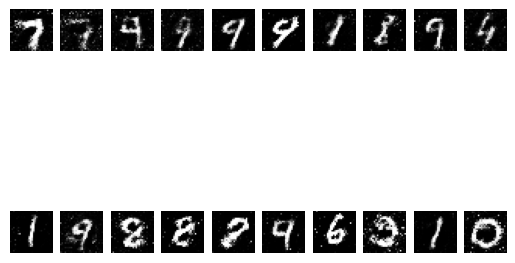

8/8 [==============================] - 0s 3ms/step
4400 loss_D 0.6305171549320221 loss_G 0.9196670651435852


8/8 [==============================] - 0s 3ms/step
4500 loss_D 0.6296027302742004 loss_G 0.896617591381073


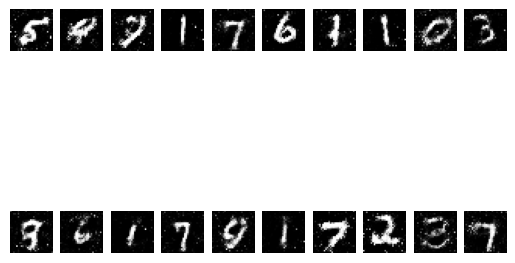

8/8 [==============================] - 0s 3ms/step
4600 loss_D 0.6259780824184418 loss_G 0.9303258657455444


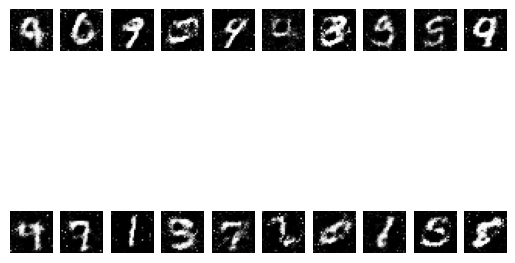

8/8 [==============================] - 0s 3ms/step
4700 loss_D 0.6456148624420166 loss_G 0.8884852528572083


8/8 [==============================] - 0s 3ms/step
4800 loss_D 0.6300700306892395 loss_G 0.9082010984420776


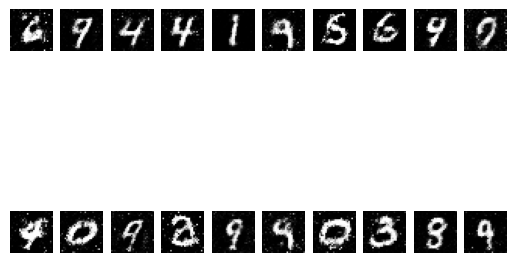

8/8 [==============================] - 0s 3ms/step
4900 loss_D 0.6520592868328094 loss_G 0.8901665806770325


8/8 [==============================] - 0s 3ms/step


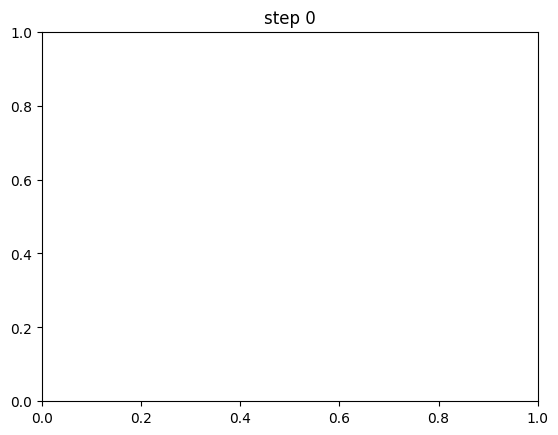

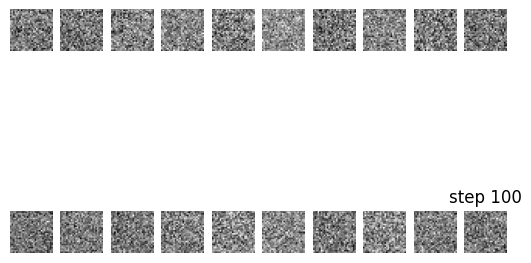

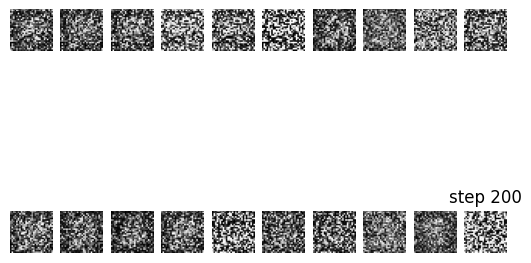

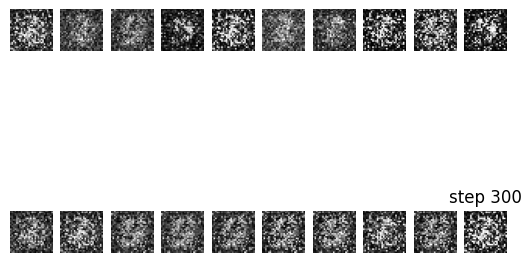

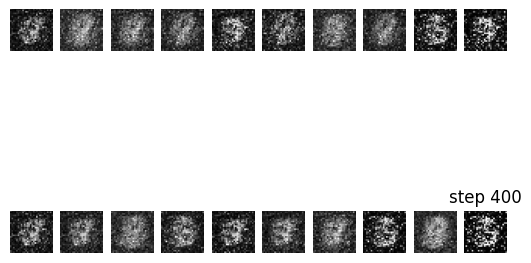

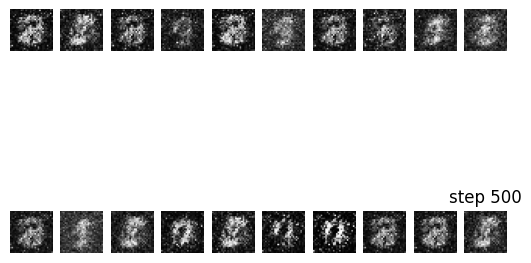

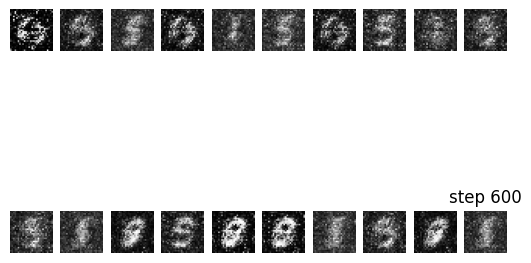

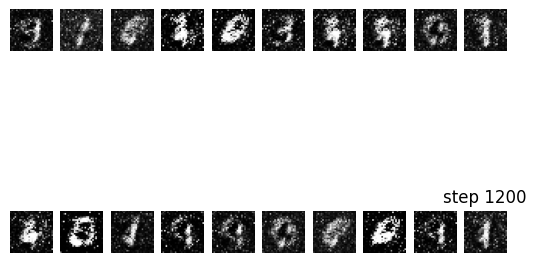

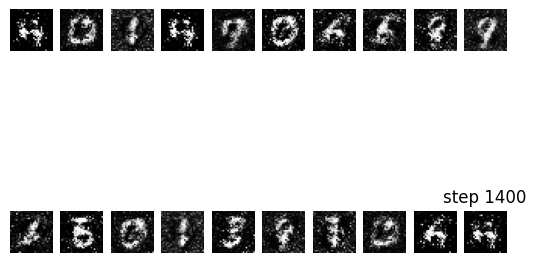

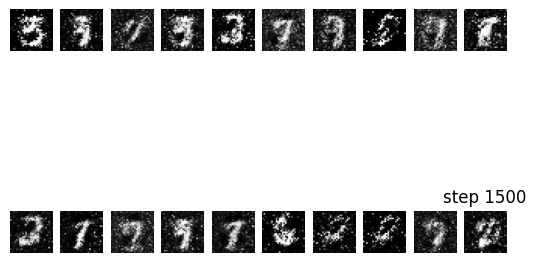

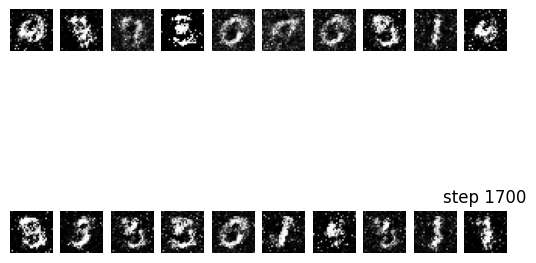

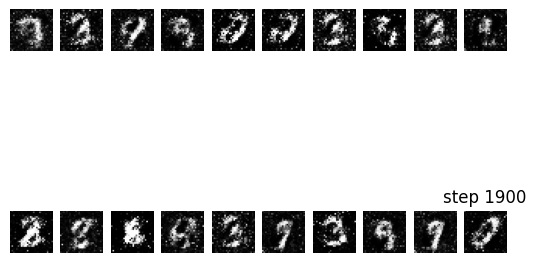

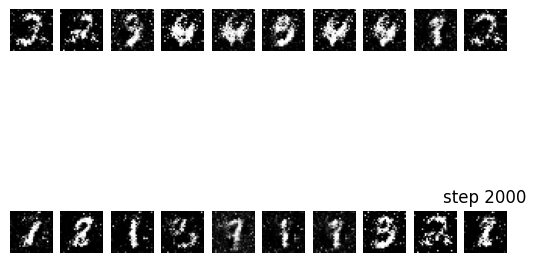

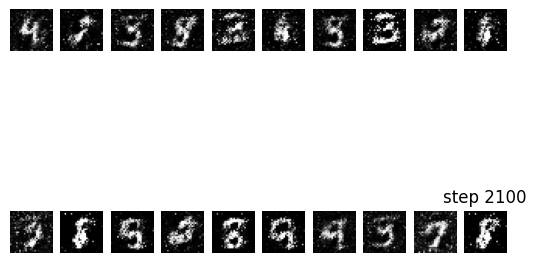

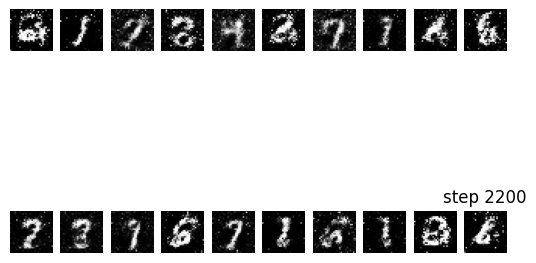

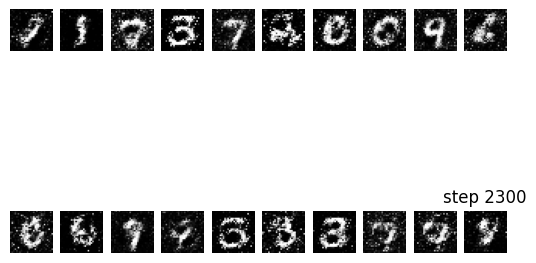

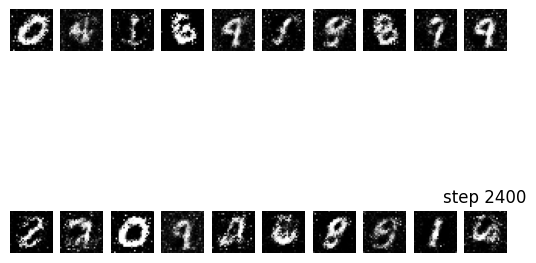

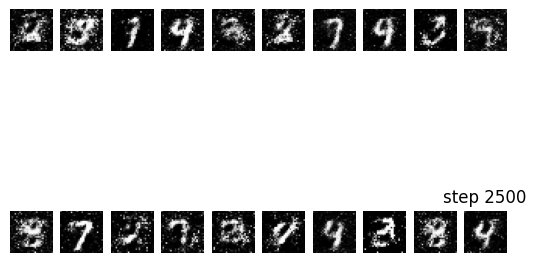

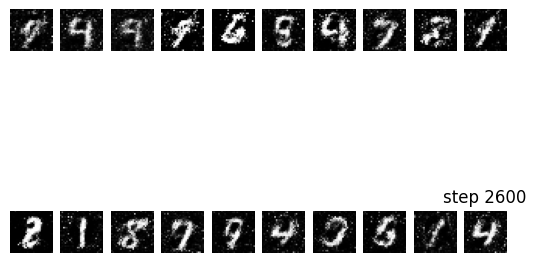

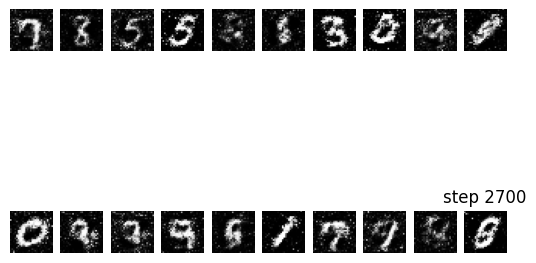

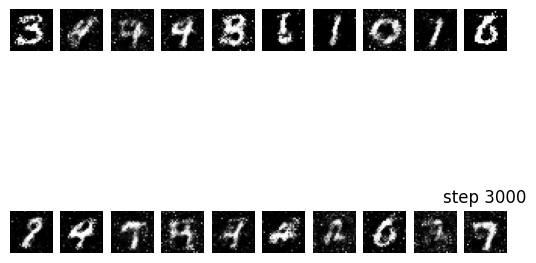

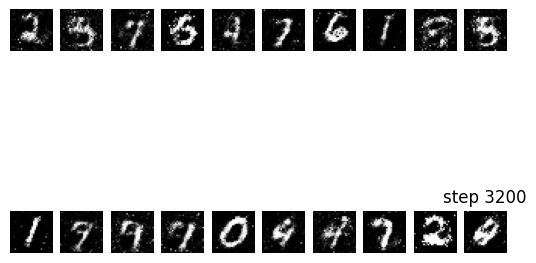

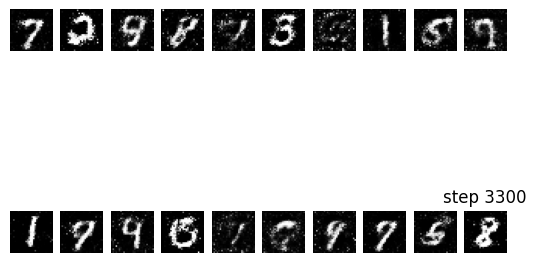

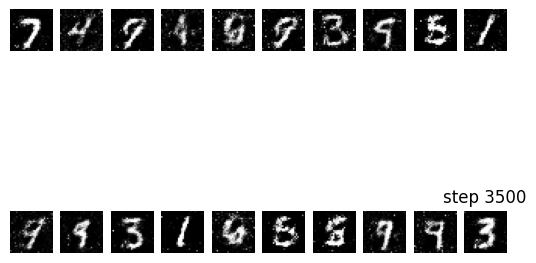

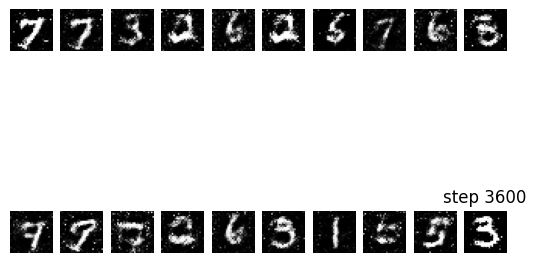

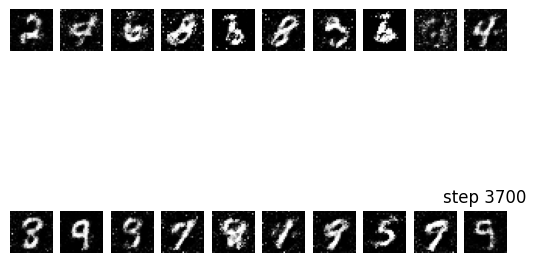

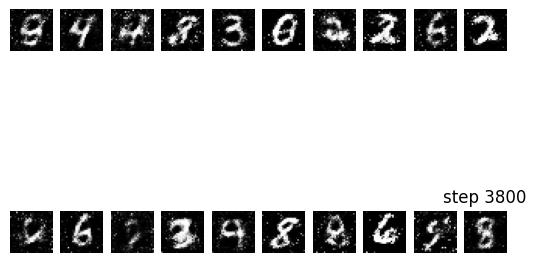

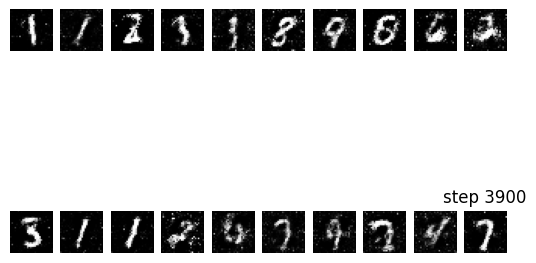

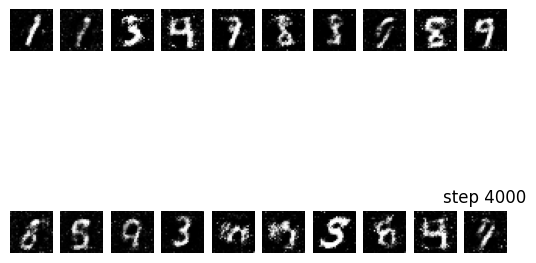

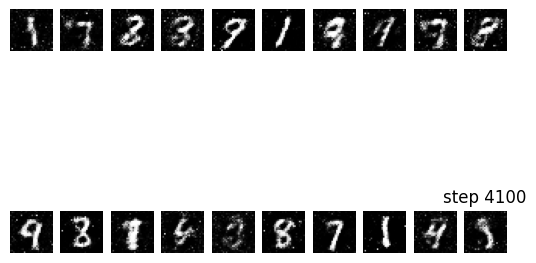

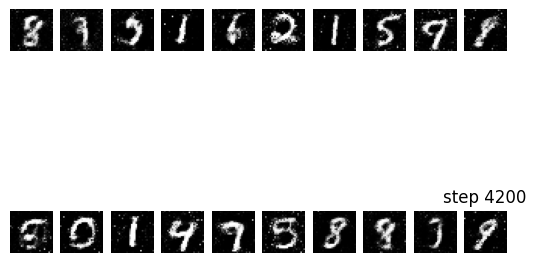

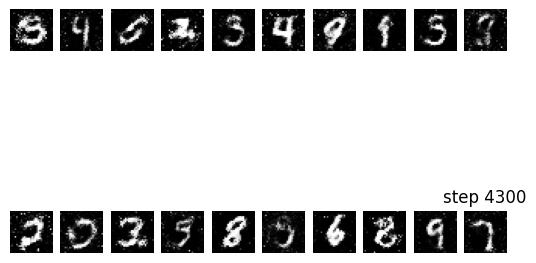

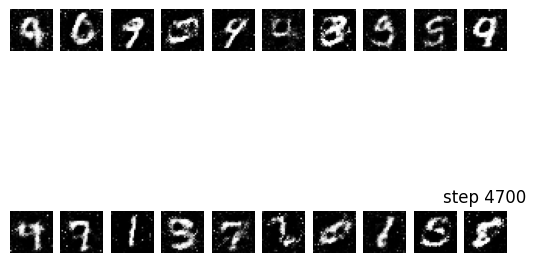

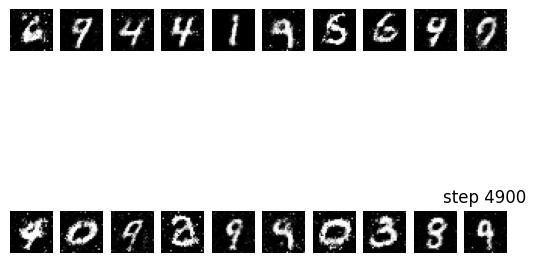

In [9]:
# training generator and discriminator
for step in range(5000):
  # select a random batch of images
  idx = idx = np.random.randint(0, x_train.shape[0], batch_size) # define batch_size number of random indexes
  imgs = imgs = x_train[idx] # select these random indexes from x_train
  # generating a batch of fake images
  noise = noise = np.random.normal(0, 1, (batch_size, gan.latent_dim)) # create batch_size number of gan.latent_dim dimensional np.random.normal noise samples with 0 mean and 1 variance
  gen_imgs = gan.generator.predict(noise)
  
  # training the discriminator
  d_loss_real = gan.discriminator.train_on_batch(imgs, valid) # train on real images with "valid" labels (1)
  d_loss_fake = gan.discriminator.train_on_batch(gen_imgs, fake) # train on fake images with "fake" labels (0)
  d_loss = 0.5 * np.add(d_loss_real, d_loss_fake) 
  
  # training the generator
  g_loss = gan.combined.train_on_batch(noise, valid) # train on fake images with "valid" labels (1)
  
  # printing out the log and plotting the generated images
  if step % 100 == 0:
    print(step, 'loss_D', d_loss[0], 'loss_G', g_loss)
    plot_images(gan, step)
    

## Inference
Generating a single image can be easily performed.

1/1 [==============================] - 0s 21ms/step


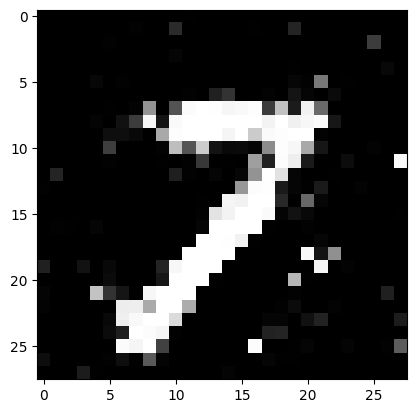

In [10]:
noise = np.random.normal(0, 1, (1, gan.latent_dim)) # defining noise for the generator for 1 image
gen_img = gan.generator.predict(noise) # generating image from noise
plt.imshow(gen_img.squeeze(), cmap='gray') # displaying the generated image